# Order Logistics Optimization


## Project Description
The objective is to build a simplified warehouse logistics optimiser that demonstrates core logic for order picking, focusing on:

- **Warehouse Modeling:** Parsing provided warehouse layout files to create a graph-based model using NetworkX. Nodes represent SKUs and edges represent walkable aisles between them.
- **Route Optimization:** Implementing algorithm to find the shortest paths between SKUs and applying a nearest-neighbor heuristic to solve a simplified Traveling Salesman Problem (TSP) for pick sequence optimization.
- **Visualisation & KPIs:** Visualizing the warehouse layout and optimised picking path using plotly, and calculating key performance indicators (KPIs) such as naive vs optimized path distances and percentage savings.

## Deliverables
- **Shortest Path Output:** algorithm results between selected SKUs.
- **Optimized Pick Sequence:** TSP heuristic results for one sample order.
- **Visualization:** Warehouse layout graph showing the optimized route.
- **Metrics:** Distances and efficiency improvements.
- **README.md:** Instructions for running the notebook and a brief on design choices and implementation strategies.

## How to Run
1. Upload all provided files (warehouse layout `.vsdx`, profile database `.accdb`, and other initial files) to the notebook's working directory (i.e., the content directory).
2. Open the Jupyter Notebook.
3. Install required packages if they are not already installed
4. Execute the cells step-by-step, following the provided instructions.
5. The code will parse the uploaded files, create the warehouse graph, and perform route optimisation.
6. The code will visualize the warehouse layout and optimised picking paths with the output metrics to evaluate the efficiency improvements.

## Design Choices
- **Graph Representation:** Used NetworkX to model the warehouse layout as a graph.
- **Shortest Path Algorithm:** algorithm for efficient and optimal pathfinding.
- **TSP Heuristic:** Nearest-neighbor heuristic applied for simplicity and speed in pick sequence optimisation.

---




In [1]:
!pip install svgpathtools
!pip install pyodbc
!apt-get install -y mdbtools unixodbc



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 4.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmdb3 libmdbsql3
Suggested packages:
  bash-completion
The following NEW packages will be installed:
  libmdb3 libmdbsql3 mdbtools unixodbc
0 upgraded, 4 newly installed, 0 to remove and 41 not upgraded.
Need to get 163 kB of archives.
After this operation, 597 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdb3 amd64 1.0.0+dfsg-1 [68.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdbsql3 amd64 1.0.0+dfsg-1 [18.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mdbtools amd64 1.0.0+dfsg-1 [48.3 kB]
Get:4 http:

Import libraries:

In [2]:
import networkx as nx
from networkx.algorithms.shortest_paths.astar import astar_path
# from svgpathtools import svg2paths
# import pyodbc
import pandas as pd
import glob
import regex as re
import os
import zipfile
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import heapq
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import xml.etree.ElementTree as ET
import csv
import zipfile

Make sure all of drivers are in the right directories:

In [3]:

# Define the source and target paths for the symbolic link
driver_path = '/usr/lib/x86_64-linux-gnu/odbc/libmdbodbc.so' # Path to the mdbtools driver
target_path = '/content/libmdbodbc.so'  # Path within Colab environment

# Create the symbolic link
if not os.path.exists(target_path):
    os.symlink(driver_path, target_path)

Create a vsdx directory to extractt files there:

In [4]:
!mkdir vsdx

# Make sure the output directory exists
os.makedirs('vsdx', exist_ok=True)

In [7]:

with zipfile.ZipFile("Warehouse layout v0.4 (3).vsdx") as z:
    # print(z.namelist())  # Lists all internal XML files

    z.extractall('vsdx')

    with z.open('visio/pages/page1.xml') as f:
        content = f.read().decode()
        # print(content[:500])  # Peek into page layout

In [8]:
!find / -name "libmdbodbc.so" 2>/dev/null

/content/libmdbodbc.so


In [9]:
!ls -l /content/libmdbodbc.so
!ls -l /usr/lib/x86_64-linux-gnu/odbc/libmdbodbc.so

lrwxrwxrwx 1 root root 44 Nov 11 19:58 /content/libmdbodbc.so -> /usr/lib/x86_64-linux-gnu/odbc/libmdbodbc.so
ls: cannot access '/usr/lib/x86_64-linux-gnu/odbc/libmdbodbc.so': No such file or directory


Check tables in the database:

In [ ]:
!mdb-tables '/content/Profile database-20190611-1335nla-wc.accdb'


Check schema in the database, data types and foreign/primary keys:

In [ ]:
!mdb-schema '/content/Profile database-20190611-1335nla-wc.accdb'

There are no FOREIGN KEY constraints defined in any of the CREATE TABLE statements. While some tables might have columns that could logically link to others (e.g., ItemNumber appearing in multiple tables), these relationships are not enforced at the database level through foreign key constraints.

Save all table names to 'table' variable:

In [12]:
# List all tables in the .accdb file
tables = !mdb-tables '/content/Profile database-20190611-1335nla-wc.accdb'

In [ ]:
tables

Iterate over each table and export it to CSV:

In [ ]:
# Iterate over each table and export it to CSV
for table in str(tables).split(' '):
    # Define the output path for the CSV
    output_csv = f'/content/{table}.csv'

    # Execute the mdb-export command
    !mdb-export '/content/Profile database-20190611-1335nla-wc.accdb' '{table}' >> '{output_csv}'


    print(f"Exported {table} ")

View content of each table:

In [15]:
paths = glob.glob('./*.csv')
for path in paths:
  # print(path)
  df = pd.read_csv(path)
  # print(df.head())
  # print( df.columns)

/tmp/ipython-input-1953786595.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipython-input-1953786595.py:4: DtypeWarning: Columns (13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


To start understanding our warehouse for the modeling project, we've loaded two key data files.

First, StorageLocationsExport.csv gives us a look at all the different storage spots we have. It is like a map of the individual shelves and areas in the warehouse, telling us how they're organized and labeled.

Second, LocationsPerSkuExport.csv tells us which products (identified by their 'ItemNumber', or SKU) are in the warehouse and how many different places each product is stored.

By looking at the first few lines of each of these files, we get a basic idea of the information they contain and how our warehouse data is structured.

In [ ]:
# Loading the relevant CSV files
storage_locations_df = pd.read_csv('./StorageLocationsExport.csv')
locations_per_sku_df = pd.read_csv('./LocationsPerSkuExport.csv')

# Displaying the first few rows to understand the data
storage_locations_df.head(), locations_per_sku_df.head()

From StorageLocationsExport.csv:

This table gives us details about the individual storage locations. For example, the first few rows show us:

Different storage areas identified by area codes and area jda,
specific storage location codes. This looks like a way to uniquely identify each shelf or bin.
Information about whether the location is and the system it belongs to.




From LocationsPerSkuExport.csv:

This table links our products (SKUs) to how many different storage locations they occupy:

The ItemNumber column is our unique identifier for each product.
CountOfStorageLocations tells us that, for instance, the first product is found in 1 location, while the second is in 2 locations.
Looking at these initial rows helps us understand how the warehouse locations are identified and how many places each product might be stored.

In [17]:
storageLocationsExport = pd.read_csv('StorageLocationsExport.csv', index_col=False)
storageLocationsExport = storageLocationsExport[['AreaCodeJda' ,'StorageLocationJda']].copy()
# Split the 'StorageLocationJda' column into three new columns
storageLocationsExport[['StorageLocationJda_Level1', 'StorageLocationJda_Level2', 'StorageLocationJda_Level3']] = storageLocationsExport['StorageLocationJda'].str.split('-', expand=True)


# Calculate the number of rows for each area.  Using .size()
area_row_counts = storageLocationsExport.groupby('AreaCodeJda').size().reset_index(name='NumberOfRows')

# Print the number of rows for each area
# print("Number of storages for each area:")
# print(area_row_counts)

The results show us the distribution of storage across different areas, like 'Small' having many more spots than 'Hazmat'.


The warehouse layout uses completely different terms than what's in the database. Instead of area codes, areas are named like 'Mezzanine', 'Standard Shelving', 'Consolidation Area', etc.


Given that our database doesn't describe this new warehouse layout with its 'Mezzanine', 'Standard Shelving', and 'Consolidation Area' structure, the next logical step would be to look at a different data source that does contain this information. We understand that this new warehouse's details are likely stored in XML data. Therefore, our next task is to parse this XML data. This will involve reading the XML files, understanding their structure and tags, and then extracting the specific information we need about the different areas (like Mezzanine, Standard Shelving, Consolidation Area) and the SKUs located within them. This parsed data will be crucial for building a model that accurately represents this new warehouse's organization and adjacency.

Parsing XML data:

In [18]:
NS = {'visio': 'http://schemas.microsoft.com/office/visio/2012/main'}

def extract_shapes_from_vsdx(vsdx_path, output_csv_path):
    with zipfile.ZipFile(vsdx_path, 'r') as vsdx:
        pages = [f for f in vsdx.namelist() if f.startswith('visio/pages/page') and f.endswith('.xml')]
        masters_map = extract_master_names(vsdx)

        rows = []

        for page in pages:
            xml_data = vsdx.read(page)
            root = ET.fromstring(xml_data)

            for shape in root.iter('{http://schemas.microsoft.com/office/visio/2012/main}Shape'):
                shape_id = shape.attrib.get('ID')
                master_id = shape.attrib.get('Master')
                shape_name = shape.attrib.get('NameU') or shape.attrib.get('Name') or ''

                # Look for text inside the shape
                text_elem = shape.find('visio:Text', NS)
                shape_text = text_elem.text.strip() if text_elem is not None and text_elem.text else ''

                data = {
                    'ID': shape_id,
                    'Name': shape_name or shape_text,
                    'Master': masters_map.get(master_id, master_id),
                    'Width': None,
                    'Height': None,
                    'PinX': None,
                    'PinY': None,
                    'Angle': None
                }

                for cell in shape.findall('visio:Cell', NS):
                    name = cell.attrib.get('N')
                    value = cell.attrib.get('V')
                    if name in data:
                        data[name] = value
                    # else:
                    #     print('>>>>>', data)

                rows.append(data)

        # Write CSV
        with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['ID', 'Name', 'Master', 'Width', 'Height', 'PinX', 'PinY', 'Angle']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for row in rows:
                writer.writerow(row)

def extract_master_names(vsdx_zip):
    """Parses master.xml to map Master IDs to Names."""
    master_map = {}
    master_files = [f for f in vsdx_zip.namelist() if f.startswith('visio/masters/master') and f.endswith('.xml')]

    for file in master_files:
        xml = ET.fromstring(vsdx_zip.read(file))

        xml_bytes = vsdx_zip.read(file)
        xml_string = xml_bytes.decode('utf-8')

        master_id = xml.attrib.get('ID')
        master_name = xml.attrib.get('NameU') or xml.attrib.get('Name')
        if master_id and master_name:
            master_map[master_id] = master_name

    return master_map


# Example usage
extract_shapes_from_vsdx('/content/Warehouse layout v0.4 (3).vsdx', 'shapes_output3.csv')


In [21]:
pd.read_csv('/content/shapes_output3.csv')[['Width', 'Height','PinX','PinY']]

,Width,Height,PinX,PinY
0,31.496063,NaN,1328.517719,533.687006
1,43.307087,141.732283,188.976378,829.921260
2,141.732283,43.307087,21.653543,70.866142
3,141.732283,NaN,1.732283,70.866142
4,141.732283,NaN,41.574803,70.866142
...,...,...,...,...
2363,39.370079,NaN,30.992126,19.685039
2364,32.283465,39.370079,482.283465,574.409449
2365,39.370079,32.283465,16.141732,19.685039
2366,39.370079,NaN,1.291339,19.685039


Looking at this new XML data, it seems we've found the key pieces of information we need to model the warehouse: the locations of our storage units (X and Y coordinates) and their shapes. This is exactly the kind of spatial data that will be crucial for determining which storage locations, and therefore the SKUs within them, are adjacent to each other.

However, we've also noticed a challenge: these X and Y location values are not in standard units like meters. This means that the raw numbers don't directly tell us the physical distance between storage units in a real-world scale. To accurately calculate adjacency based on proximity, we will need to convert these location units into a consistent and meaningful unit of measurement later in our process. Once converted, these coordinates and shapes will allow us to define adjacency based on actual physical closeness within the warehouse.

# Creating a graph

We've taken that X and Y location data from the XML and visually represented it by plotting all the storage units on an X-Y plot. This gives us a spatial understanding of how everything is laid out.

To make our model more realistic for how pickers actually move, we've made a couple of key assumptions and added some detail:

First, we've recognized that storage rows next to each other might not be directly accessible from both sides. This means a picker might have to go around the end of a row to access the adjacent one. To account for this, we've likely defined access to be primarily from one side of a row.

Second, to accurately calculate distances and create a traversable network, we've introduced additional nodes in the aisles between the storage units. Think of these as points in the walkways. This allows us to represent the aisles as paths with defined segments, making it possible to calculate the distance a picker would travel between different storage locations.

Finally, we've also added additional steps or nodes on the perimeter of the storage area. This likely represents the entry and exit points, as well as potential pathways around the entire storage space.

By doing this, we've moved beyond just plotting the storage locations and have created a more detailed spatial network that approximates the actual movement and accessibility within the warehouse. This enriched representation, with aisle nodes and perimeter steps, will be crucial for accurately calculating distances and ultimately building our adjacency matrix based on how a picker would navigate the space.

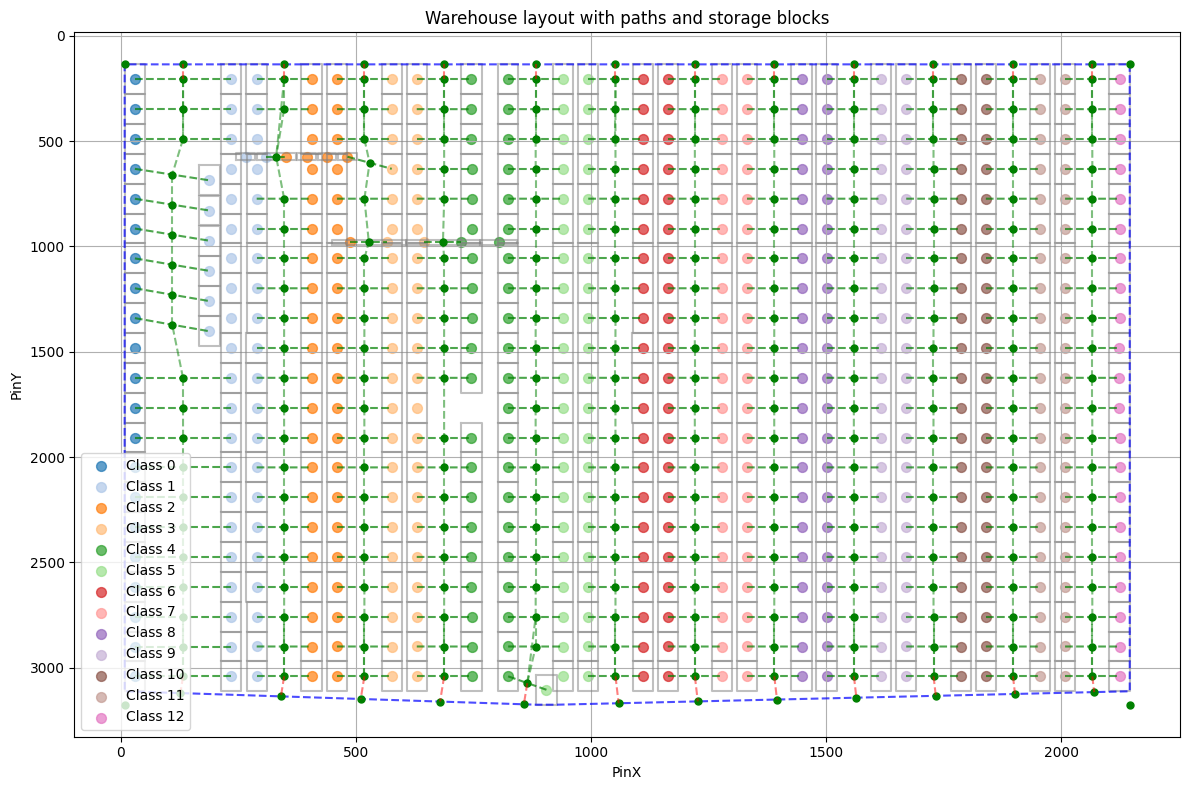

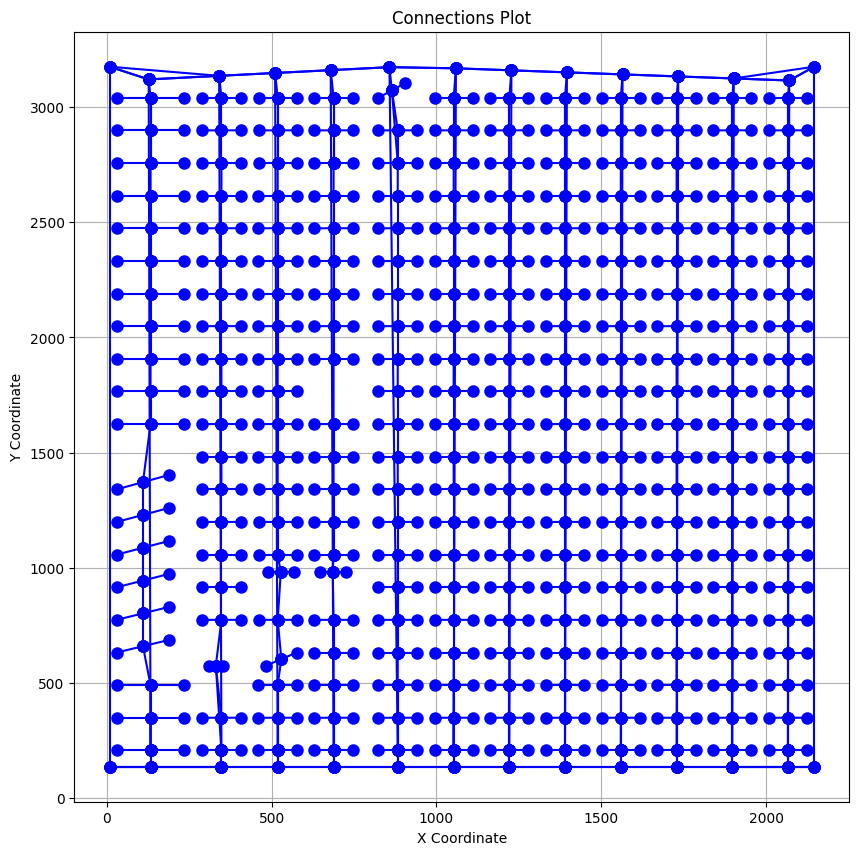

In [22]:
def point_to_segment_distance(px, py, x1, y1, x2, y2):
    """
    Calculate the shortest distance between a point (px, py) and a line segment
    defined by (x1, y1) and (x2, y2).
    """
    # If the segment is just a point
    if x1 == x2 and y1 == y2:
        return distance.euclidean((px, py), (x1, y1))

    # Calculate the dot product
    dx = x2 - x1
    dy = y2 - y1
    t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

    # Find the closest point on the segment
    if t < 0:
        closest_x = x1
        closest_y = y1
    elif t > 1:
        closest_x = x2
        closest_y = y2
    else:
        closest_x = x1 + t * dx
        closest_y = y1 + t * dy
    # Calculate the distance to the closest point
    return distance.euclidean((px, py), (closest_x, closest_y))

def find_closest_point_on_segment(px, py, x1, y1, x2, y2):
        """
        Find the closest point on a line segment defined by (x1, y1) and (x2, y2)
        to the point (px, py).
        """
        if x1 == x2 and y1 == y2:
            return (x1, y1)

        # Calculate the dot product
        dx = x2 - x1
        dy = y2 - y1
        t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

        # Find the closest point on the segment
        if t < 0:
            closest_x = x1
            closest_y = y1
        elif t > 1:
            closest_x = x2
            closest_y = y2
        else:
            closest_x = x1 + t * dx
            closest_y = y1 + t * dy
        return (closest_x, closest_y)



# Load the data from the CSV file
try:
    df = pd.read_csv('/content/shapes_output3.csv')
except FileNotFoundError:
    print("Error: 'shapes_output3.csv' not found. Please make sure the file is in the same directory as the script.")
    exit()

# Filter the DataFrame to include only rows where the 'Name' starts with 'Standard'
df_standard = df[df['Name'].str.startswith('Standard', na=False)].copy()

if df_standard.empty:
    print("No 'Standard' shapes found in the data.")
    exit()

# Fill NaN values
df_standard['Width'] = df_standard['Width'].fillna(0)
df_standard['Height'] = df_standard['Height'].fillna(0)

# 1. Identify 13 classes (columns) using K-means clustering on PinX
kmeans = KMeans(n_clusters=13, random_state=0, n_init=10)
df_standard['Class'] = kmeans.fit_predict(df_standard[['PinX']])

# 2. Calculate the approximate center of each class
class_centers = df_standard.groupby('Class').agg({'PinX': 'mean', 'PinY': 'mean'}).reset_index()

# 3. Order Classes by X and Closeness
class_centers = class_centers.sort_values(by='PinX')  # Initial sort by X
class_centers_array = class_centers[['PinX', 'PinY']].values


def calculate_total_distance(order):
    """Calculates the total distance between consecutive classes in the given order."""
    total_dist = 0  # Initialize total_distance
    for i in range(len(order) - 1):
        total_dist += distance.euclidean(class_centers_array[order[i]], class_centers_array[order[i + 1]])
    return total_dist


# Refine order by closeness (simplified neighbor swap)
num_classes = len(class_centers)
order = list(range(num_classes))  # Initial order
improved = True
while improved:
    improved = False
    for i in range(num_classes - 1):
        # Try swapping with the next class
        new_order = order[:]
        new_order[i], new_order[i + 1] = new_order[i + 1], new_order[i]
        if calculate_total_distance(new_order) < calculate_total_distance(order):
            order = new_order
            improved = True
    # Even simpler: Just do one pass.
    break

# Apply the refined order
ordered_class_centers = class_centers.iloc[order]
ordered_class_centers['NewClass'] = list(range(num_classes))  # Create a new class number
class_mapping = dict(zip(ordered_class_centers['Class'], ordered_class_centers['NewClass']))
df_standard['Class'] = df_standard['Class'].map(class_mapping) # Fixes the error.

# 4. Number Classes - already done in the reordering

# 5. Connect closest storage units between adjacent classes AND ends
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.get_cmap('tab20')

# Scatter plot for the 'Standard' shapes, colored by class
for c in range(num_classes):
    class_data = df_standard[df_standard['Class'] == c]
    ax.scatter(class_data['PinX'], class_data['PinY'], s=50, alpha=0.7, color=cmap(c % 20), label=f'Class {c}')

# Annotate each point
for i, row in df_standard.iterrows():
    label = ''  # Set label to empty string
    ax.annotate(label, (row['PinX'], row['PinY']), textcoords="offset points", xytext=(5, 5), ha='left')

# Add rectangles
for i, row in df_standard.iterrows():
    width = row['Width']
    height = row['Height']
    pin_x = row['PinX']
    pin_y = row['PinY']
    angle_rad = row['Angle'] if pd.notna(row['Angle']) else 0
    corners_x = np.array([-width / 2, width / 2, width / 2, -width / 2, -width / 2])
    corners_y = np.array([-height / 2, -height / 2, height / 2, height / 2, -height / 2])
    rotated_x = pin_x + (corners_x * np.cos(angle_rad) - corners_y * np.sin(angle_rad))
    rotated_y = pin_y + (corners_x * np.sin(angle_rad) + corners_y * np.cos(angle_rad))
    if width > 0 and height > 0:
        ax.plot(rotated_x, rotated_y, color='gray', alpha=0.5)


# Connect closest storage units between adjacent classes
midpoints = []
connections = []
class_midpoint_dict = {}  # Store the class(es) each midpoint connects

for c in range(num_classes - 1):
    # Get the storage units in the current class (c) and the next class (c+1)
    class_c_storages = df_standard[df_standard['Class'] == c]
    class_c_plus_1_storages = df_standard[df_standard['Class'] == c + 1]

    # Find the closest pairs of storage units (one from each class)
    closest_pairs = []
    closest_from_c1 = {}
    closest_from_c2 = {}

    for i, row_i in class_c_storages.iterrows():
        min_distance_c1 = float('inf')
        closest_j_c1 = -1
        for j, row_j in class_c_plus_1_storages.iterrows():
            dist = distance.euclidean((row_i['PinX'], row_i['PinY']), (row_j['PinX'], row_j['PinY']))
            if dist < min_distance_c1:
                min_distance_c1 = dist
                closest_j_c1 = j
        if closest_j_c1 != -1:
            closest_from_c1[i] = closest_j_c1

    for j, row_j in class_c_plus_1_storages.iterrows():
        min_distance_c2 = float('inf')
        closest_i_c2 = -1
        for i, row_i in class_c_storages.iterrows():
            dist = distance.euclidean((row_i['PinX'], row_i['PinY']), (row_j['PinX'], row_j['PinY']))
            if dist < min_distance_c2:
                min_distance_c2 = dist
                closest_i_c2 = i
        if closest_i_c2 != -1:
            closest_from_c2[j] = closest_i_c2

    # now connect only the closest
    for i, j in closest_from_c1.items():
        if closest_from_c2.get(j) == i:
            x1, y1 = df_standard.loc[i]['PinX'], df_standard.loc[i]['PinY']
            x2, y2 = df_standard.loc[j]['PinX'], df_standard.loc[j]['PinY']
            ax.plot([x1, x2], [y1, y2], color='green', alpha=0.7, linestyle='--')
            # calculate midpoint
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            midpoints.append((mid_x, mid_y))
            connections.append([(x1, y1), (mid_x, mid_y), (x2, y2)])  # Keep track of the connections
            class_midpoint_dict[(mid_x, mid_y)] = (c, c + 1) # Store the classes

# 4. Draw a line around the perimeter, accounting for storage sizes
min_x = df_standard['PinX'].min()
max_x = df_standard['PinX'].max()
min_y = df_standard['PinY'].min()
max_y = df_standard['PinY'].max()

# Find the extreme points of the rectangles
extreme_points = []
for i, row in df_standard.iterrows():
    width = row['Width'] / 2
    height = row['Height'] / 2
    pin_x = row['PinX']
    pin_y = row['PinY']
    angle_rad = row['Angle'] if pd.notna(row['Angle']) else 0

    # Calculate the corners
    corners_x = np.array([-width, width, width, -width])
    corners_y = np.array([-height, -height, height, height])

    # Rotate the corners
    rotated_x = pin_x + (corners_x * np.cos(angle_rad) - corners_y * np.sin(angle_rad))
    rotated_y = pin_y + (corners_x * np.sin(angle_rad) + corners_y * np.cos(angle_rad))

    # Add the rotated corners to the list
    for k in range(4):
        extreme_points.append([rotated_x[k], rotated_y[k]])

# Find convex hull of the extreme points
perimeter_points = []
perimeter_connections = []
# perimeter_lines = []
if len(extreme_points) > 3:
    hull = ConvexHull(np.array(extreme_points))
    perimeter_x = []
    perimeter_y = []
    for vertex in hull.vertices:
        perimeter_x.append(extreme_points[vertex][0])
        perimeter_y.append(extreme_points[vertex][1])
    perimeter_x.append(perimeter_x[0])
    perimeter_y.append(perimeter_y[0])
    ax.plot(perimeter_x, perimeter_y, color='blue', alpha=0.7, linestyle='--')
    perimeter_points = list(zip(perimeter_x, perimeter_y))
    # perimeter_lines.append((perimeter_points[-1], perimeter_points[0]))  # close the loop
# print('perimeter_lines', perimeter_lines)
# plot midpoints
for i, (mid_x, mid_y) in enumerate(midpoints):
    ax.plot(mid_x, mid_y, 'go', markersize=5)
    # ax.annotate(str(i), (mid_x, mid_y), color='green', fontsize=10, ha='center', va='bottom') #show the number

# Connect midpoints to each other and perimeter
midpoint_connections = {i: [] for i in range(len(midpoints))}
lonely_midpoints = [] # Keep track of midpoints with only one connection

# 6. Add perimeter points
perimeter_points_to_add = []
new_perimeter_midpoints = [] # Keep track of the new perimeter points
new_perimeter_connections = []
all_perimeter_points = []

# Find corner points
if len(perimeter_points) > 0:
    min_x_perimeter = min(p[0] for p in perimeter_points)
    max_x_perimeter = max(p[0] for p in perimeter_points)
    min_y_perimeter = min(p[1] for p in perimeter_points)
    max_y_perimeter = max(p[1] for p in perimeter_points)

    corner_points = [
        (min_x_perimeter, min_y_perimeter),
        (min_x_perimeter, max_y_perimeter),
        (max_x_perimeter, min_y_perimeter),
        (max_x_perimeter, max_y_perimeter),
    ]

    for corner_point in corner_points:
        all_perimeter_points.append(corner_point)
        if corner_point not in perimeter_points:
            perimeter_points_to_add.append(corner_point)
    perimeter_connections.append([(min_x_perimeter, min_y_perimeter), (min_x_perimeter, max_y_perimeter)])
    perimeter_connections.append([(max_x_perimeter, min_y_perimeter), (max_x_perimeter, max_y_perimeter)])

    # Find points on perimeter between classes
    for c in range(num_classes - 1):
        class_c_midpoints = [
            (x, y) for i, (x, y) in enumerate(midpoints)
            if class_midpoint_dict.get((x, y)) == (c, c + 1)
            or class_midpoint_dict.get((x, y)) == (c + 1, c)
        ]
        if len(class_c_midpoints) > 0:
            # Find the midpoint with the minimum Y value
            min_y_midpoint = min(class_c_midpoints, key=lambda p: p[1])
            max_y_midpoint = max(class_c_midpoints, key=lambda p: p[1])

            closest_perimeter_point_min = None
            closest_perimeter_point_max = None
            min_dist_to_perimeter_min = float('inf')
            min_dist_to_perimeter_max = float('inf')
            for i in range(len(perimeter_points) -1):
                p1 = perimeter_points[i]
                p2 = perimeter_points[i+1]
                dist_to_segment_min = point_to_segment_distance(min_y_midpoint[0], min_y_midpoint[1], p1[0], p1[1], p2[0], p2[1])
                dist_to_segment_max = point_to_segment_distance(max_y_midpoint[0], max_y_midpoint[1], p1[0], p1[1], p2[0], p2[1])
                if dist_to_segment_min < min_dist_to_perimeter_min:
                    min_dist_to_perimeter_min = dist_to_segment_min
                    closest_perimeter_point_min = find_closest_point_on_segment(min_y_midpoint[0], min_y_midpoint[1], p1[0], p1[1], p2[0], p2[1])
                if dist_to_segment_max < min_dist_to_perimeter_max:
                    min_dist_to_perimeter_max = dist_to_segment_max
                    closest_perimeter_point_max = find_closest_point_on_segment(max_y_midpoint[0], max_y_midpoint[1], p1[0], p1[1], p2[0], p2[1])

            if closest_perimeter_point_min not in perimeter_points_to_add and closest_perimeter_point_min not in perimeter_points:
                    perimeter_points_to_add.append(closest_perimeter_point_min)
                    new_perimeter_midpoints.append(closest_perimeter_point_min) #store
                    new_perimeter_connections.append((min_y_midpoint[0], min_y_midpoint[1], closest_perimeter_point_min[0], closest_perimeter_point_min[1]))
                    perimeter_connections.append([(min_y_midpoint[0], min_y_midpoint[1]), (closest_perimeter_point_min[0], closest_perimeter_point_min[1])])
                    all_perimeter_points.append((closest_perimeter_point_min[0], closest_perimeter_point_min[1]))
            if closest_perimeter_point_max not in perimeter_points_to_add and closest_perimeter_point_max not in perimeter_points:
                    perimeter_points_to_add.append(closest_perimeter_point_max)
                    new_perimeter_midpoints.append(closest_perimeter_point_max) #store
                    new_perimeter_connections.append((max_y_midpoint[0], max_y_midpoint[1], closest_perimeter_point_max[0], closest_perimeter_point_max[1]))
                    perimeter_connections.append([(min_y_midpoint[0], min_y_midpoint[1]),
                                                  (closest_perimeter_point_max[0], closest_perimeter_point_max[1])])
                    all_perimeter_points.append((closest_perimeter_point_max[0], closest_perimeter_point_max[1]))

    # Add new perimeter points to the perimeter_points list
    perimeter_points.extend(perimeter_points_to_add)
    for p in perimeter_points_to_add:
        ax.plot(p[0], p[1], 'go', markersize=5)  # Plot the new perimeter points in green
        #  ax.annotate(str(len(midpoints) + i), p, color='green', fontsize=10, ha='center', va='bottom') #show the number

#plot new perimeter connections
for (x1,y1,x2,y2) in new_perimeter_connections:
    perimeter_connections.append([(x1,y1), (x2,y2)])
    ax.plot([x1,x2],[y1,y2], 'r--', alpha = 0.5)

# 7. Connect midpoints to each other and perimeter
for i, (mid_x1, mid_y1) in enumerate(midpoints):
    # Find distances to all other midpoints
    distances_to_other_midpoints = []
    for j, (mid_x2, mid_y2) in enumerate(midpoints):
        if i != j:
            dist = distance.euclidean((mid_x1, mid_y1), (mid_x2, mid_y2))
            distances_to_other_midpoints.append((dist, j))

    # Sort by distance
    distances_to_other_midpoints.sort()

    # Connect to the closest midpoints, up to 2
    num_connections = len(midpoint_connections[i])
    for dist, j in distances_to_other_midpoints:
        if num_connections < 2:
            other_midpoint_classes = class_midpoint_dict.get(midpoints[j])
            current_midpoint_classes = class_midpoint_dict.get((mid_x1, mid_y1))
            if other_midpoint_classes is not None and current_midpoint_classes is not None:
                # Check if they share the same two classes
                if (set(other_midpoint_classes) == set(current_midpoint_classes)):
                    if j not in midpoint_connections[i]: # Check for duplicates
                        ax.plot([mid_x1, midpoints[j][0]], [mid_y1, midpoints[j][1]], 'g--', alpha=0.5)
                        midpoint_connections[i].append(j)
                        midpoint_connections[j].append(i)
                        connections.append([(mid_x1, mid_y1), (midpoints[j][0], midpoints[j][1])])
                        num_connections += 1
            elif num_connections == 0: #connect to any other midpoint if no class match
                    if j not in midpoint_connections[i]: # Check for duplicates
                        ax.plot([mid_x1, midpoints[j][0]], [mid_y1, midpoints[j][1]], 'g--', alpha=0.5)
                        midpoint_connections[i].append(j)
                        midpoint_connections[j].append(i)
                        connections.append([(mid_x1, mid_y1), (midpoints[j][0], midpoints[j][1])])
                        num_connections += 1

        if num_connections >= 2:
            break


ax.set_xlabel("PinX")
ax.set_ylabel("PinY")
ax.set_title("Warehouse layout with paths and storage blocks")
ax.invert_yaxis()
ax.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Create the adjacency matrix
all_points = []
storage_points = []
for i, row in df_standard.iterrows():
    storage_points.append((row['PinX'], row['PinY']))
    all_points.append((row['PinX'], row['PinY']))

for mx, my in midpoints:
    all_points.append((mx, my))

for px, py in perimeter_points:
    all_points.append((px, py))

# all_perimeter_connections = perimeter_points
# Connect each perimeter point to its two closest neighbors
all_perimeter_connections = [] # Initialize empty list
if all_perimeter_points: # Check if there are perimeter points.
    for i, p1 in enumerate(all_perimeter_points):
        # Calculate distances to all other perimeter points
        distances = []
        for j, p2 in enumerate(all_perimeter_points):
            if i != j:
                dist = distance.euclidean(p1, p2)
                distances.append((dist, j))
        distances.sort()  # Sort by distance

        # Connect to the two closest points
        for k in range(min(2, len(distances))):  # Connect to at most 2
            closest_point_index = distances[k][1]
            p2 = all_perimeter_points[closest_point_index]
            all_perimeter_connections.append((p1, p2)) # Append the pair of points

# print(all_perimeter_connections) # Print the result




connections.extend(perimeter_connections)
connections.extend(all_perimeter_connections)




num_points = len(all_points)
adjacency_matrix = np.zeros((num_points, num_points))

# # 1. Storage unit connections (from the original dataframe)
# for i, row in df_standard.iterrows():
#     x1, y1 = row['PinX'], row['PinY']
#     for j, row2 in df_standard.iterrows():
#         if i != j:
#             x2, y2 = row2['PinX'], row2['PinY']
#             # Check if this connection exists in the 'connections' list
#             if any(
#                 (
#                     (x1 == c1[0] and y1 == c1[1] and x2 == c2[0] and y2 == c2[1])
#                     or (x2 == c1[0] and y2 == c1[1] and x1 == c2[0] and y1 == c2[1])
#                 )
#                 for c1, c2, *_ in connections # Accept 2 or 3 points
#             ):
#                 index1 = all_points.index((x1, y1))
#                 index2 = all_points.index((x2, y2))
#                 adjacency_matrix[index1, index2] = 1
#                 adjacency_matrix[index2, index1] = 1  # The graph is undirected

# 2. Midpoint connections
def split_connections(connections):
    """
    Splits 3-point connections into two 2-point connections.

    Args:
        connections: A list of connections, where each connection is a list of 2 or 3 tuples.

    Returns:
        A new list of connections, where each connection is a list of 2 tuples.
    """
    new_connections = []
    for connection in connections:
        if len(connection) == 2:
            new_connections.append(connection)  # Keep 2-point connections as they are
        elif len(connection) == 3:
            c1, c2, c3 = connection
            new_connections.append([c1, c2])  # Create connection 1: start to midpoint
            new_connections.append([c2, c3])  # Create connection 2: midpoint to end
    return new_connections

connections = split_connections(connections) # Modify the original connections list


for connection in connections:
    if len(connection) == 2:
        c1, c2 = connection
        p1_in_all = False
        p2_in_all = False
        index1 = -1
        index2 = -1
        for i, p in enumerate(all_points):
            if c1[0] == p[0] and c1[1] == p[1]:
                index1 = i
                p1_in_all = True
            if c2[0] == p[0] and c2[1] == p[1]:
                index2 = i
                p2_in_all = True
        if p1_in_all and p2_in_all:
            adjacency_matrix[index1, index2] = 1
            adjacency_matrix[index2, index1] = 1

def plot_connections(connections):
    """
    Plots the connections (dots and lines) on a coordinate plot.

    Args:
        connections: A list of connections, where each connection is a list of 2 tuples.
    """
    plt.figure(figsize=(10, 10))  # Adjust figure size as needed
    plt.title("Connections Plot")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)

    for connection in connections:
        if len(connection) == 2:
            start_x, start_y = connection[0]
            end_x, end_y = connection[1]
            plt.plot([start_x, end_x], [start_y, end_y], 'b-', marker='o', markersize=8, label='Connection')  # Plot line and dots
        elif len(connection) == 3:
            start_x, start_y = connection[0]
            mid_x, mid_y = connection[1]
            end_x, end_y = connection[2]
            plt.plot([start_x, mid_x], [start_y, mid_y], 'g-', marker='o', markersize=8, label='Connection1')  # start to mid
            plt.plot([mid_x, end_x], [mid_y, end_y], 'r-', marker='o', markersize=8, label='Connection2')  # mid to end

    # Add a legend.  This can cause multiple labels, which is fine for now.
    #plt.legend()
    plt.show()

# Assuming 'connections' list is available from the previous code
plot_connections(connections)
np.save('connections_df.npy', np.array(connections))

We've also classified the storage rows. This step was key to explicitly defining how the aisles and pathways are structured, essentially creating the 'streets' and 'blocks' of our warehouse map. By categorizing these rows, we could then logically connect them with the aisle nodes we previously added.

The resulting layout of these classified storage rows and connecting aisles now visually resembles the example warehouse image we looked at earlier. This means we've successfully translated the abstract X-Y coordinates and storage unit placements into a structured network of aisles and storage blocks that mirrors a real-world warehouse environment. This visual and logical alignment with the example image gives us confidence that our representation of the walkable paths and the overall spatial organization is becoming increasingly accurate.

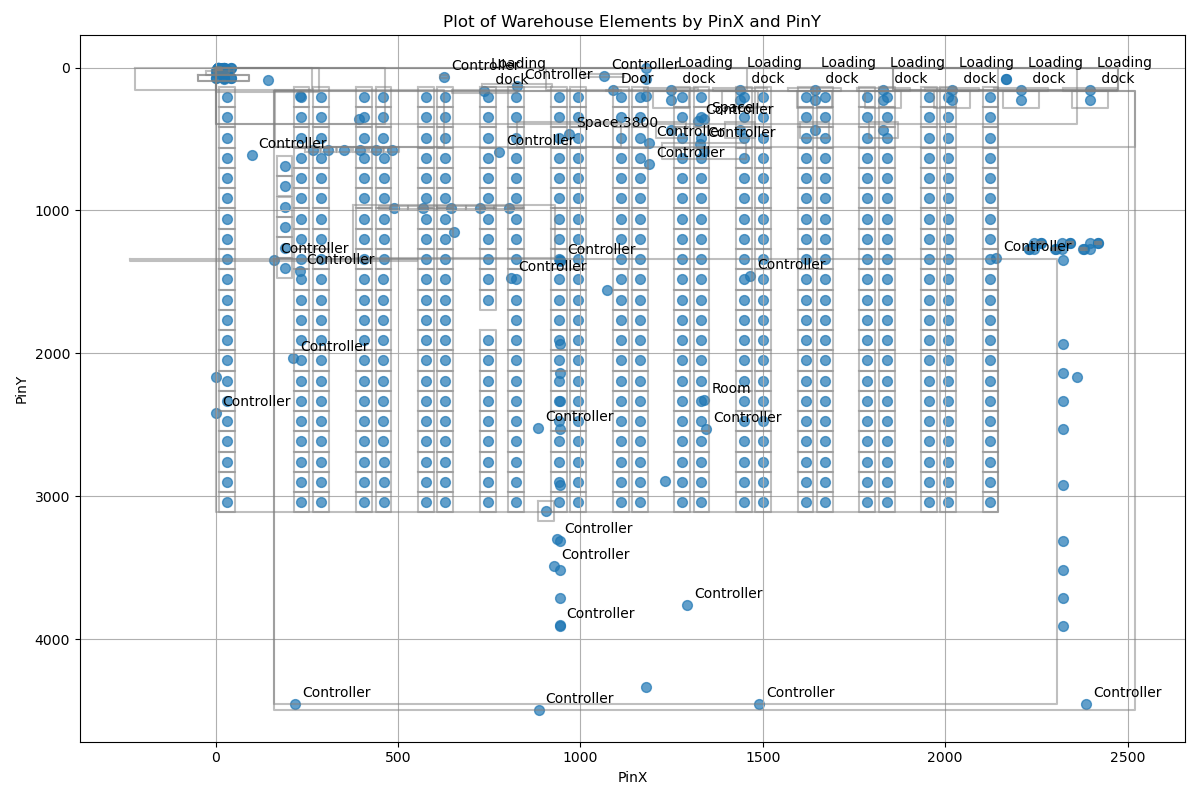

And with classified storage rows and paths.

It's important to note that our current focus for this detailed spatial modeling, with the plotted storage units, aisle nodes, perimeter steps, and classified storage rows creating walkable paths, is specifically on the main storage area of the warehouse.

While we know there are other areas like the 'Mezzanine' and 'Consolidation Area' mentioned earlier, our current data and therefore our detailed network representation, are primarily concentrated on the section containing the main storage rows. This is because we currently lack sufficient information or detailed spatial data about the layout and accessibility within those other areas. As a result, our adjacency calculations and walkable path analysis will, for now, be limited to this main storage section where we have the necessary location and structural information.


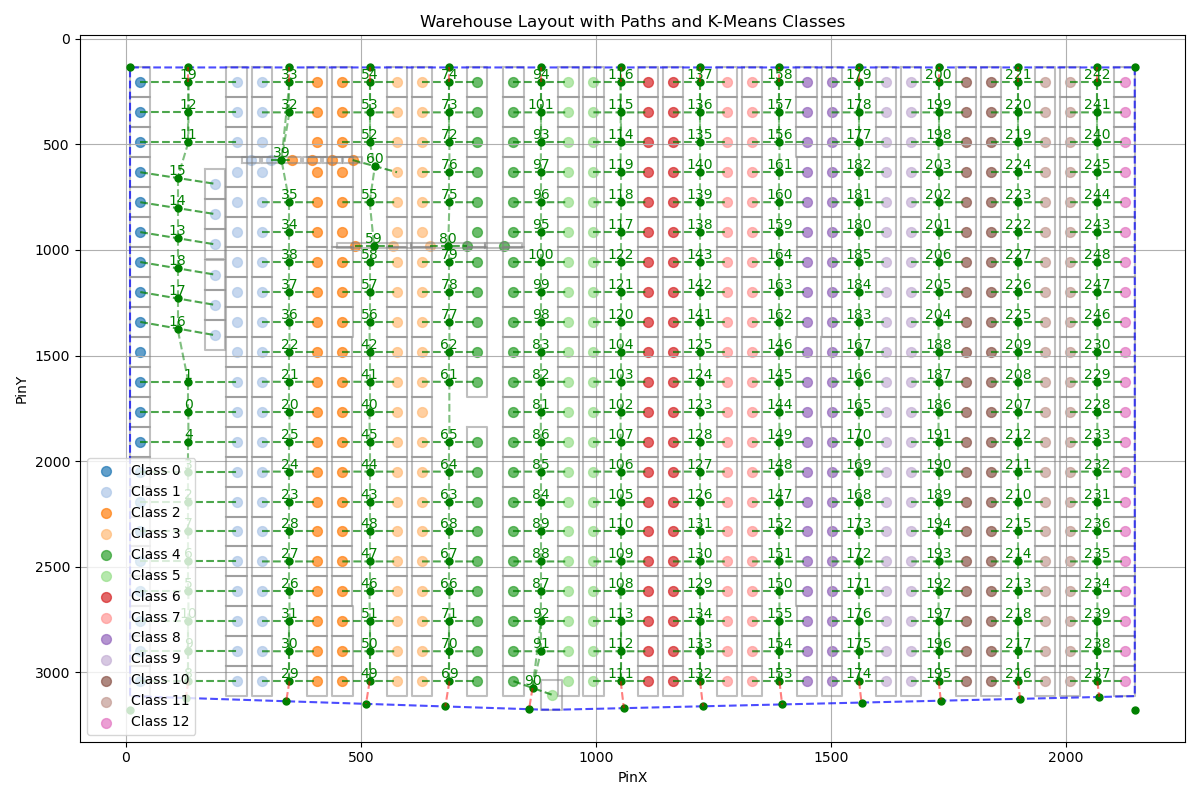

Here's a breakdown of the code we're using for pathfinding and optimizing picking routes in our warehouse:

First, we define some **scaling factors** (`x_mmeters` and `y_mmeters`). These represent the approximate real-world dimensions (in millimeters) of the main storage area we're focusing on. We'll use these to convert the raw coordinates from our data into meters so we can work with real-world distances.

The `scale` function takes these dimension values and a list of all the points in our warehouse network (storage locations and the intermediate nodes we added in the aisles). It figures out the original range of the X and Y coordinates and then calculates the scaling factors needed to fit this layout within our defined meter dimensions, making sure the proportions are maintained. The output of this function gives us the conversion rates from our raw units to meters for both the X and Y axes.

The `plot_shortest_path` function is for visualizing our warehouse layout and the paths. It takes all the points, the sequence of points in the shortest path, our initial defined connections between points, and optionally the sequence of points in an optimized TSP route. It first scales all the coordinates to meters using our `scale` function. Then, it plots all the individual points. It also draws the initial connections we defined as dashed blue lines, calculating the total length of these initial, likely inefficient, connections. The calculated shortest path (found using the A* algorithm) is then drawn as a solid red line with markers. If we have a TSP route (the best order to visit multiple SKUs), it highlights these SKUs in green and numbers them to show the visitation order. Finally, it calculates the total distance of the optimized shortest path and displays this along with the distance of our initial connections and the percentage of travel saved. The plot is labeled and titled to make it easy to understand.

The `create_weighted_adjacency_matrix` function is crucial for building the 'map' our pathfinding algorithms will use. It takes our list of defined connections between points. For every pair of connected points, it calculates the actual physical distance between them using the standard Euclidean distance formula. It then creates a 'weighted adjacency matrix'. Imagine this as a table where each row and column represents a point in our warehouse. If two points are directly connected, the cell at their intersection in the table will contain the distance between them (the 'weight'). If they are not directly connected, the cell will be zero. This matrix essentially encodes the entire network of our main storage area and the 'cost' (distance) of moving between any two directly linked locations.

The `a_star_shortest_path` function implements the A* search algorithm. This is a powerful algorithm for finding the shortest path between two points in a graph (like our warehouse network). It takes our weighted adjacency matrix, the starting point (SKU location), the ending point (another SKU location), and the list of all points. A* intelligently explores the possible paths by considering both the distance already traveled and an estimate of the distance remaining to the goal (using a 'heuristic' function). This makes it much more efficient than simply exploring all possible paths. It returns the sequence of point indices that form the shortest path between the start and end SKUs.

The `heuristic` function provides that estimate of the remaining distance for A*. In our case, it simply calculates the straight-line (Euclidean) distance between the current point and the target point. This is a common and effective heuristic for spatial problems.

The `tsp` function attempts to solve the Traveling Salesman Problem (TSP) for a set of SKUs we need to pick. Given a starting SKU and a list of other SKUs to visit, it tries to find the most efficient order to visit all of them, without needing to return to the start. It uses our `a_star_shortest_path` function to find the shortest path between each pair of SKUs and employs a 'Nearest Neighbor' strategy. Starting from the initial SKU, it finds the closest unvisited SKU, moves there (using the A* shortest path), and repeats this process until all SKUs have been visited. This gives us a good, though not always absolutely optimal, sequence for picking.

Finally, the main part of the code first loads our defined connections to create the weighted adjacency matrix and the list of all points. Then, we define a starting SKU and a list of SKUs we want to visit for an example order. Depending on whether we have just one SKU to visit or multiple, we either directly use A* to find the shortest path to that single SKU or we use our `tsp` function to find the best order to visit multiple SKUs. After finding the path (or the order), we print the sequence of SKU indices and their corresponding coordinates. We then use the `plot_shortest_path` function to visualize the results, showing the initial connections, the optimized path, and the calculated distances and savings.

Optimal order of SKUs to visit: [15, 38, 20, 54, 21, 28, 60]


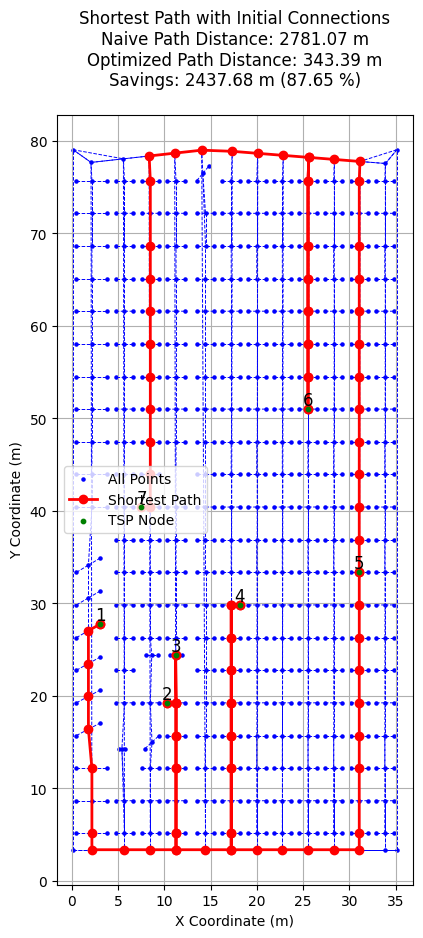

Total distance: 343.39 m


In [ ]:

# Define scaling factors
x_mmeters = 35000  # mm
y_mmeters = 75666  # mm


def scale(x_mmeters, y_mmeters, all_points):
    # Extract x and y coordinates from all_points
    x_coords = [point[0] for point in all_points]
    y_coords = [point[1] for point in all_points]

    # Find min and max X and Y for scaling
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)
    x_range = max_x - min_x
    y_range = max_y - min_y

    # Calculate scaling factors, ensuring proportionality
    x_scale_meters = x_mmeters / x_range if x_range > 0 else 1
    y_scale_meters = y_mmeters / y_range if y_range > 0 else 1

    x_scale_meters = x_scale_meters / 1000
    y_scale_meters = y_scale_meters / 1000

    return x_scale_meters, y_scale_meters


def plot_shortest_path(all_points, shortest_path_indices, connections_np_array, tsp_path_indices=None):
    """
    Plots the shortest path and the initial connections on a 2D graph.
    Scales the X and Y coordinates before plotting.

    Args:
        all_points (list): List of all points (tuples of coordinates).
        shortest_path_indices (list): List of indices representing the shortest path.
        connections_np_array (numpy.ndarray): NumPy array representing the initial connections.
        tsp_path_indices (list, optional): List of indices representing the TSP path.
    """
    if not shortest_path_indices:
        print("No path to plot.")
        return

    # Extract x and y coordinates from all_points
    x_coords = [point[0] for point in all_points]
    y_coords = [point[1] for point in all_points]

    # Scale the coordinates
    x_scale, y_scale = scale(x_mmeters, y_mmeters, all_points)

    # Extract the coordinates of the shortest path
    scaled_path_x = [x_coord * x_scale for x_coord in x_coords]
    scaled_path_y = [y_coord * y_scale for y_coord in y_coords]

    path_x = [scaled_path_x[i] for i in shortest_path_indices]
    path_y = [scaled_path_y[i] for i in shortest_path_indices]
    # Plot all points
    plt.scatter(scaled_path_x, scaled_path_y, s=5, color='blue', label='All Points')
    # Plot the initial connections
    naive_path_distance = 0
    for row in connections_np_array:
        start_point = tuple(row[0])
        end_point = tuple(row[1])
        point1_index = all_points.index(start_point)
        point2_index = all_points.index(end_point)
        # Scale the coordinates before calculating distance
        scaled_point1 = (scaled_path_x[point1_index], scaled_path_y[point1_index])
        scaled_point2 = (scaled_path_x[point2_index], scaled_path_y[point2_index])

        naive_path_distance += distance.euclidean(scaled_point1, scaled_point2)  # already scaled

        plt.plot(
            [scaled_path_x[point1_index], scaled_path_x[point2_index]],
            [scaled_path_y[point1_index], scaled_path_y[point2_index]],
            color='blue',
            linestyle='--',
            linewidth=0.7,
        )



    # Plot the shortest path
    plt.plot(path_x, path_y, color='red', linewidth=2, marker='o', label='Shortest Path')

    # If TSP path is provided, plot it
    if tsp_path_indices:
        tsp_path_x = [scaled_path_x[i] for i in tsp_path_indices]
        tsp_path_y = [scaled_path_y[i] for i in tsp_path_indices]
        # plt.plot(tsp_path_x, tsp_path_y, color='green', linewidth=2, marker='o', label='TSP Path')
        # Color the TSP nodes in green
        # Color the TSP nodes in green
        for idx, i in enumerate(tsp_path_indices):
            plt.scatter(scaled_path_x[i], scaled_path_y[i], s=10, color='green', zorder=10, label='TSP Node' if idx == 0 else "")
            plt.text(scaled_path_x[i], scaled_path_y[i], str(idx + 1), color='black', fontsize=12, ha='center', va='bottom', zorder=10)





    # Calculate total distance of the shortest path
    optimized_path_distance = 0
    for i in range(len(shortest_path_indices) - 1):
        # Scale the coordinates before calculating distance
        scaled_point1 = (scaled_path_x[shortest_path_indices[i]], scaled_path_y[shortest_path_indices[i]])
        scaled_point2 = (scaled_path_x[shortest_path_indices[i + 1]], scaled_path_y[shortest_path_indices[i + 1]])
        optimized_path_distance += distance.euclidean(scaled_point1, scaled_point2)  # already scaled

    # Calculate savings
    savings = naive_path_distance - optimized_path_distance
    savings_percentage = (savings / naive_path_distance) * 100 if naive_path_distance > 0 else 0

    # Add labels and title
    plt.xlabel("X Coordinate (m)")
    plt.ylabel("Y Coordinate (m)")
    title = (
        f"Shortest Path with Initial Connections\n"
        f"Naive Path Distance: {naive_path_distance:.2f} m\n"
        f"Optimized Path Distance: {optimized_path_distance:.2f} m\n"
        f"Savings: {savings:.2f} m ({savings_percentage:.2f} %)\n"
    )
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gcf().set_size_inches(12, 10)
    plt.show()
    return naive_path_distance, optimized_path_distance



def create_weighted_adjacency_matrix(connections_np_array):
    """
    Creates a weighted adjacency matrix from a NumPy array of connections.

    Args:
        connections_np_array (numpy.ndarray): A NumPy array containing the connections.
    Returns:
        numpy.ndarray: A weighted adjacency matrix.
    """
    # Remove duplicate rows
    connections_np_array = np.unique(connections_np_array, axis=0)

    all_points = set()
    for row in connections_np_array:
        start_point = tuple(row[0])
        end_point = tuple(row[1])
        all_points.add(start_point)
        all_points.add(end_point)

    all_points = list(all_points)

    # Initialize the weighted adjacency matrix with zeros
    num_points = len(all_points)
    weighted_adjacency_matrix = np.zeros((num_points, num_points))

    # Create a mapping from points to indices
    point_to_index = {point: i for i, point in enumerate(all_points)}
    # Iterate through the connections in the NumPy array
    for row in connections_np_array:
        start_point = tuple(row[0])
        end_point = tuple(row[1])
        start_index = point_to_index[start_point]
        end_index = point_to_index[end_point]

        # Calculate the distance between the start and end points (edge weight)
        weight = distance.euclidean(start_point, end_point)

        # Update the adjacency matrix with the weight
        weighted_adjacency_matrix[start_index, end_index] = weight
        weighted_adjacency_matrix[end_index, start_index] = weight  # The graph is undirected

    for i in range(num_points):  # Ensure diagonal is zero
        weighted_adjacency_matrix[i, i] = 0

    return weighted_adjacency_matrix, all_points



def a_star_shortest_path(weighted_adjacency_matrix, start_sku, end_sku, all_points):
    """
    Finds the shortest path between two SKUs using the A* algorithm.

    Args:
        weighted_adjacency_matrix (numpy.ndarray): The weighted adjacency matrix representing the warehouse layout.
        start_sku (int): The index of the starting SKU in the all_points list.
        end_sku (int): The index of the destination SKU in the all_points list.
        all_points (list):  The list of all points.

    Returns:
        list: A list of point indices representing the shortest path, or None if no path is found.
    """

    num_points = len(weighted_adjacency_matrix)
    if start_sku < 0 or start_sku >= num_points or end_sku < 0 or end_sku >= num_points:
        print("Error: Start or end SKU index out of bounds.")
        return None

    # Create a priority queue for nodes to visit
    open_set = [(0, start_sku)]  # (f_score, node_index)
    came_from = {}  # Store the path
    g_score = {start_sku: 0}  # Cost from start to current node
    f_score = {start_sku: heuristic(all_points[start_sku], all_points[end_sku])}  # Estimated total cost

    while open_set:
        # Get the node with the lowest f_score
        _, current_sku = heapq.heappop(open_set)

        if current_sku == end_sku:
            # Reconstruct the path
            path = []
            while current_sku in came_from:
                path.append(current_sku)
                current_sku = came_from[current_sku]
            path.append(start_sku)
            path.reverse()
            return path

        # Get neighbors of the current node
        neighbors = []
        for i in range(num_points):
            if weighted_adjacency_matrix[current_sku, i] > 0:  # Check for connections
                neighbors.append(i)

        for neighbor_sku in neighbors:
            # Calculate the tentative g_score
            tentative_g_score = g_score[current_sku] + weighted_adjacency_matrix[current_sku, neighbor_sku]

            if neighbor_sku not in g_score or tentative_g_score < g_score[neighbor_sku]:
                # Found a better path to this neighbor
                came_from[neighbor_sku] = current_sku
                g_score[neighbor_sku] = tentative_g_score
                f_score[neighbor_sku] = tentative_g_score + heuristic(all_points[neighbor_sku], all_points[end_sku])
                heapq.heappush(open_set, (f_score[neighbor_sku], neighbor_sku))

    # If the open set is empty and we haven't reached the goal, no path was found
    print("No path found between the specified SKUs.")
    return None


def heuristic(point1, point2):
    """
    Calculates the Euclidean distance between two points as a heuristic for A*.
    """
    return distance.euclidean(point1, point1)


def tsp(weighted_adjacency_matrix, start_sku, skus_to_visit, all_points):
    """
    Solves the Traveling Salesman Problem (TSP) for a given set of SKUs using A*
    as the shortest path algorithm and the Nearest Neighbor heuristic.

    Args:
        weighted_adjacency_matrix (numpy.ndarray): The weighted adjacency matrix.
        start_sku (int): The starting SKU index.
        skus_to_visit (list): A list of SKU indices to visit.
        all_points (list): List of all points.

    Returns:
        list: A list of SKU indices representing the order to visit the SKUs,
              or None if no path is found.
    """
    num_points = len(weighted_adjacency_matrix)
    if not skus_to_visit:
        return [start_sku]  # Nothing to visit, return start

    # Include the starting SKU in the list of points to visit
    all_skus = [start_sku] + skus_to_visit
    current_node = start_sku
    path = [start_sku]
    unvisited_nodes = set(skus_to_visit)

    # Use Nearest Neighbor to construct a path
    while unvisited_nodes:
        nearest_node = -1
        min_distance = float('inf')

        for next_node in unvisited_nodes:
            # Use A* to find the shortest path between current and next node
            shortest_path = a_star_shortest_path(weighted_adjacency_matrix, current_node, next_node, all_points)
            if shortest_path:
                # Calculate the distance of the shortest path
                path_distance = sum(weighted_adjacency_matrix[shortest_path[i], shortest_path[i+1]] for i in range(len(shortest_path)-1))
                if path_distance < min_distance:
                    min_distance = path_distance
                    nearest_node = next_node

        if nearest_node == -1:
            print("Warning: Disconnected graph.  Partial path found.")
            break  # or handle as appropriate for your application

        # Add the nearest node to the path
        path.append(nearest_node)
        unvisited_nodes.remove(nearest_node)
        current_node = nearest_node

    return path



# 1.  Call the function to create the weighted adjacency matrix
connections_df = np.load("connections_df.npy")  # this is how the data gets loaded.
weighted_adj_matrix, all_points = create_weighted_adjacency_matrix(connections_df)


# 2. Define the starting SKU and the SKUs to visit
start_sku = 15
skus_to_visit = [20, 21, 60, 38, 54, 28] # Example list of SKUs to visit

# 3.  Check the number of SKUs to visit and call appropriate function
if len(skus_to_visit) == 1:
    # If there is only one SKU to visit, use A* directly
    shortest_path_indices = a_star_shortest_path(weighted_adj_matrix, start_sku, skus_to_visit[0], all_points)
    if shortest_path_indices:
        print("Shortest path SKU indices:", shortest_path_indices)
        print("Shortest path coordinates:", [all_points[i] for i in shortest_path_indices])
        naive_path_distance, optimized_path_distance = plot_shortest_path(all_points, shortest_path_indices, connections_df)
        print(f"Total distance: {optimized_path_distance:.2f} m")
    else:
        print("No shortest path found.")
else:
    # Otherwise, use the TSP function
    optimal_order = tsp(weighted_adj_matrix, start_sku, skus_to_visit, all_points)
    if optimal_order:
        print("Optimal order of SKUs to visit:", optimal_order)
        shortest_path_indices_tsp = []
        for i in optimal_order:
            shortest_path_indices = a_star_shortest_path(weighted_adj_matrix, start_sku, i, all_points)
            start_sku = i
            shortest_path_indices_tsp.extend(shortest_path_indices)
        naive_path_distance, optimized_path_distance = plot_shortest_path(all_points, shortest_path_indices_tsp, connections_df, tsp_path_indices=optimal_order)
        print(f"Total distance: {optimized_path_distance:.2f} m")
    else:
        print("No optimal path found.")



# An example


Let's look at how the code we just described actually finds a picking route using the TSP approach:

First, we define a `start_sku` (in the example, it's SKU with index 6 in our internal representation). This is where the picker begins their route for a particular order.

Then, we have a list called `skus_to_visit` (like `[12, 53, 89, 3, 56, 33]`). This list contains the indices of the storage locations where the items for the current order are located. Our goal is to find the most efficient order to visit all of these locations starting from `start_sku`.


1.  It starts at the `start_sku` (6).
2.  It looks at all the SKUs in `skus_to_visit` that haven't been visited yet.
3.  For each unvisited SKU, it uses our `a_star_shortest_path` function to find the shortest path from the *current* location to that unvisited SKU, considering the aisles and the distances between storage units in our warehouse network (represented by the `weighted_adj_matrix`).
4.  It calculates the total distance of each of these shortest paths.
5.  It selects the unvisited SKU that has the *shortest* path from the current location. This is the "nearest neighbor" approach.
6.  It adds this nearest SKU to our `optimal_order` list (the sequence of SKUs to visit) and marks it as visited.
7.  The current location is now updated to this newly visited SKU.
8.  This process repeats until all the SKUs in `skus_to_visit` have been added to the `optimal_order`.

So, after the `tsp` function runs, the `optimal_order` list will contain a sequence of SKU indices, starting with our `start_sku` and followed by the other SKUs in an order that the algorithm estimates will result in a relatively short total travel distance.

Once we have this `optimal_order`, the code then iterates through this sequence. For each SKU in the `optimal_order`, it uses `a_star_shortest_path` again to find the actual detailed shortest path (the sequence of all the points, including aisle nodes, to traverse) from the current location to the next SKU in the optimal order. These detailed paths are collected in `shortest_path_indices_tsp`.

Finally, the `plot_shortest_path` function is called. This visualizes the entire journey: it shows all the storage locations and aisle nodes, the initial connections we defined, and the optimized route (the sequence of points in `shortest_path_indices_tsp`), highlighting the SKUs in the `optimal_order` with green circles and their visitation number. The plot also calculates and displays the total distance of this optimized route and compares it to the distance of a naive route based on the initial connections.

In essence, the code first figures out a good *order* to visit the required SKUs using a nearest neighbor approach guided by shortest paths (found with A*), and then it determines the detailed shortest path to travel between these SKUs in that optimized order. The plotting function then helps us see the result and understand the potential savings in travel distance.

Optimal order of SKUs to visit: [6, 56, 3, 89, 33, 12, 53]


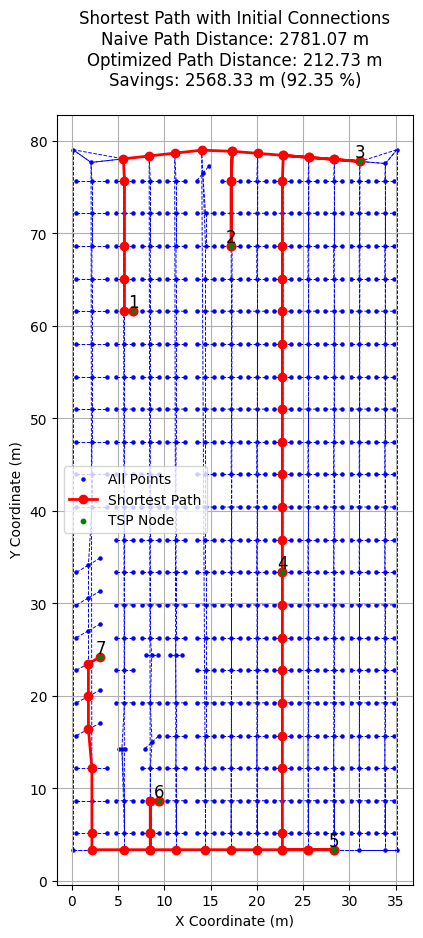

Total distance: 212.73 m


In [ ]:
start_sku = 6
skus_to_visit = [12, 53, 89, 3, 56, 33] # Example list of SKUs to visit

# 3.  Check the number of SKUs to visit and call appropriate function
if len(skus_to_visit) == 1:
    # If there is only one SKU to visit, use A* directly
    shortest_path_indices = a_star_shortest_path(weighted_adj_matrix, start_sku, skus_to_visit[0], all_points)
    if shortest_path_indices:
        print("Shortest path SKU indices:", shortest_path_indices)
        print("Shortest path coordinates:", [all_points[i] for i in shortest_path_indices])
        naive_path_distance, optimized_path_distance = plot_shortest_path(all_points, shortest_path_indices, connections_df)
        print(f"Total distance: {optimized_path_distance:.2f} m")
    else:
        print("No shortest path found.")
else:
    # Otherwise, use the TSP function
    optimal_order = tsp(weighted_adj_matrix, start_sku, skus_to_visit, all_points)
    if optimal_order:
        print("Optimal order of SKUs to visit:", optimal_order)
        shortest_path_indices_tsp = []
        for i in optimal_order:
            shortest_path_indices = a_star_shortest_path(weighted_adj_matrix, start_sku, i, all_points)
            start_sku = i
            shortest_path_indices_tsp.extend(shortest_path_indices)
        naive_path_distance, optimized_path_distance = plot_shortest_path(all_points, shortest_path_indices_tsp, connections_df, tsp_path_indices=optimal_order)
        print(f"Total distance: {optimized_path_distance:.2f} m")
    else:
        print("No optimal path found.")

# README.md


## Implementation Steps and Considerations

### 1. Understanding the Initial Data

We started by examining the provided database tables to understand the available information about SKUs and their locations. The tables included:

* `StorageLocationsExport`: Providing details about individual storage locations, including area codes and specific location identifiers.
* `LocationsPerSkuExport`: Linking SKUs to the number of storage locations they occupy.

These initial tables gave us a foundational understanding of the warehouse structure and the presence of SKUs. However, they lacked the detailed spatial information needed to directly build an adjacency matrix based on physical proximity.

### 2. Shifting Focus to Spatial Data

Recognising the limitations of the initial database tables for spatial modeling, we shifted our focus to a different data source, which we understood to be in **XML format**. This new data source contained crucial information about the warehouse layout, including:

* **Storage Locations (X and Y coordinates):** Precise spatial coordinates for each storage unit.
* **Storage Shapes:** Information about the physical dimensions and form of each storage unit.

We identified that these X and Y locations, while critical for determining adjacency, were in units other than meters, necessitating a conversion step later in the process.

### 3. Building the Walkable Network

To model how a picker navigates the warehouse, we moved beyond just the static locations of storage units. We performed the following steps:

* **Plotting Storage Locations:** The X and Y coordinates of all storage units were plotted to visualize the spatial layout.
* **Considering Access Restrictions:** We assumed that storage rows next to each other might only be accessible from one side, reflecting real-world aisle constraints.
* **Creating Aisle Nodes:** We introduced additional nodes in the aisles between storage units. These nodes represent points in the walkable pathways, allowing us to calculate distances along the aisles.
* **Adding Perimeter Steps:** We also added nodes around the perimeter of the storage area to account for entry/exit points and potential travel around the edges.
* **Classifying Storage Rows:** We categorized the storage rows to explicitly define the structure of the walkable paths and aisles, aligning with the visual layout of a typical warehouse.

This process transformed the raw spatial data into a network of interconnected points representing the navigable space within the main storage area.

### 4. Implementing the Algorithm for Shortest Paths

With the walkable network established, we implemented the **A\* search algorithm** to find the shortest path between any two points (SKU locations or aisle nodes) within the main storage area. A\* uses a heuristic (in our case, the Euclidean distance) to efficiently explore the network and find the optimal path based on the distances between connected points.

### 5. Applying a Nearest Neighbor Heuristic for TSP

To optimize the picking route for an order with multiple items, we employed a **Nearest Neighbor heuristic** to solve a simplified Traveling Salesman Problem (TSP) without the requirement of returning to the starting point (Open TSP).

The algorithm works as follows:

1.  Start at a designated starting SKU location.
2.  Identify all the other SKUs that need to be picked for the order.
3.  From the current location, use the A\* algorithm to find the shortest path to each unvisited SKU.
4.  Select the unvisited SKU that is closest (has the shortest path) to the current location.
5.  Move to that SKU, mark it as visited, and repeat the process until all required SKUs have been visited.

This heuristic provides a reasonably efficient picking sequence without the computational complexity of more advanced TSP solvers.

### 6. Visualization and Evaluation

Finally, we visualized the warehouse layout, the initial connections, and the optimized picking path using `matplotlib`. The visualization helps in understanding the efficiency of the generated route. We also calculated key performance indicators (KPIs):

* **Naive Path Distance:** The total distance based on direct, unoptimized connections.
* **Optimized Path Distance:** The total distance of the route determined by the TSP heuristic and A\* algorithm.
* **Percentage Savings:** The reduction in travel distance achieved by the optimization.

These metrics allow us to quantify the potential improvements in picking efficiency achieved by our simplified routing optimiser.



## Future Improvements

Several areas for future improvement could significantly enhance the accuracy and scope of this order picking optimization model:

* **Connectivity Enhancements:** Address potential issues with node connectivity within the generated network to ensure all reachable storage locations are properly linked by walkable paths.
* **Distance Metric Refinement:** Explore alternative distance metrics beyond Euclidean distance. **Manhattan distance** might be more representative of movement along aisles, or more sophisticated metrics could be developed based on actual picker movement patterns and potential obstructions.
* **Comprehensive Data Integration:** The current model primarily focuses on the main storage area based on the parsed XML data. Obtaining **master XML files** that provide a complete and consistent representation of the entire warehouse layout would be invaluable for a more holistic model.
* **Database and Spatial Data Linking:** Establish a direct link between the X and Y location data from the XML files and the SKU information from the database (`StorageLocationsExport`, `LocationsPerSkuExport`). This would allow us to directly associate SKUs with their precise spatial locations.
* **Expanding TSP Scope:** Extend the TSP optimization to include all relevant warehouse areas (e.g., Mezzanine, Consolidation Area), not just the standard shelving area. This would require integrating the spatial data and network representation for these additional zones.

These future improvements would lead to a more accurate, comprehensive, and ultimately more effective logistics optimisation solution.
